In [1]:
!pip install -U torch==1.7.1 torchtext==0.4.0

# Reload environment
exit()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.8/776.8 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 6.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1
    Uninstalling torchtext-0.15.1:
      Successfully uninstalled torchtext-0.15.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.7.1 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.7.1 which is incompatible.
torchaudio 2.0.1+cu118 requires torch==2.0.0, but

# Importing Required Library

In [33]:
import torch
import torchtext
from torchtext.data import Field, BucketIterator
import csv
import torch.nn as nn
from torchtext.datasets import TranslationDataset
from torchtext.data import TabularDataset
import random
import time
import matplotlib.pyplot as plt

# Device config

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Drive Mount

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# File path

In [4]:
train_path = '/content/drive/MyDrive/Dataset/Dakshina Dataset/hi/lexicons/hi.translit.sampled.train.tsv'
test_path = '/content/drive/MyDrive/Dataset/Dakshina Dataset/hi/lexicons/hi.translit.sampled.test.tsv'
val_path = '/content/drive/MyDrive/Dataset/Dakshina Dataset/hi/lexicons/hi.translit.sampled.dev.tsv'

# Field Cration

In [5]:
source_field = Field(tokenize=list, init_token='<sos>', eos_token='<eos>')
target_field = Field(tokenize=list, init_token='<sos>', eos_token='<eos>')

datafields=[('source', source_field), ('target', target_field)]

# Create Dataset

In [6]:
train_dataset = TabularDataset(path=train_path, format='tsv', fields=[('source', source_field), ('target', target_field)])
# train_dataset, test_dataset, val_dataset = TabularDataset.splits(
#     path='/content/drive/MyDrive/Dataset/Dakshina Dataset/hi/lexicons/',
#     train='hi.translit.sampled.train.tsv',
#     test='hi.translit.sampled.test.tsv',
#     validation = 'hi.translit.sampled.dev.tsv',
#     format='csv',
#     skip_header=True,
#     fields=datafields
# )


# Build Vocab

In [7]:
source_field.build_vocab(train_dataset.source)
target_field.build_vocab(train_dataset.target)

# Hyper Parameter

In [8]:
batch_size = 32
teacher_force_ratio = 0.5

# Create Iterator for each train, test and val

In [9]:
train_iter = BucketIterator(
    dataset = train_dataset,
    batch_size = 32,
    device = device
)

# train_iter, val_iter, test_iter = BucketIterator.splits(
#     datasets=(train_dataset, val_dataset, test_dataset),
#     batch_sizes=(batch_size, batch_size, batch_size),
#     sort_key=lambda x: len(x.text),
#     sort_within_batch=True,
#     device=device
# )

In [10]:
source_field.tokenize('Rutvik')
target_field.tokenize('अंकगणित')

['अ', 'ं', 'क', 'ग', 'ण', 'ि', 'त']

In [11]:
source_field.vocab

# Model creation
reference : https://www.youtube.com/watch?v=EoGUlvhRYpk

## Encoder

In [44]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        return hidden, cell

## Decoder Model

In [47]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super(Decoder, self).__init__()
        self.output_dim = output_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.out(output.squeeze(0))
        return prediction, hidden, cell

## Seq2Seq model

In [48]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, device):
    super(Seq2Seq, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.device = device


  def forward(self, src, trg, teacher_forcing_ratio=0.5):
    batch_size = trg.shape[1]
    max_len = trg.shape[0]
    trg_vocab_size = self.decoder.output_dim
    
    outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
    
    hidden, cell = self.encoder(src)
    
    input = trg[0,:]
    
    for t in range(1, max_len):
        output, hidden, cell = self.decoder(input, hidden, cell)
        outputs[t] = output
        teacher_force = random.random() < teacher_forcing_ratio
        top1 = output.argmax(1)
        input = trg[t] if teacher_force else top1
    
    return outputs


# Dimension Defination

In [15]:
INPUT_DIM = len(source_field.vocab)
OUTPUT_DIM = len(target_field.vocab)

In [35]:
def train(ENC_EMB_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, DEC_DROPOUT):
    enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
    dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
    model = Seq2Seq(enc, dec, device).to(device)

    print(f"Train model for Input Embedding:{ENC_EMB_DIM} | number of encoding and decoding layers : {N_LAYERS} | Hidden layer Size : {HID_DIM} ")

    # Define the optimizer and the loss function
    criterion = nn.CrossEntropyLoss(ignore_index=target_field.vocab.stoi['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    N_EPOCHS = 15
    CLIP = 1
    start = time.time()

    corr_tbl = torch.zeros((OUTPUT_DIM, OUTPUT_DIM), dtype=torch.long)
    total_correct = 0
    total_tokens = 0
    
    train_losses = []
    train_accs = []

    for epoch in range(N_EPOCHS):
        epoch_loss = 0
        epoch_correct = 0
        epoch_tokens = 0
        model.train()
        
        for batch in train_iter:
            src = batch.source
            trg = batch.target
            optimizer.zero_grad()
            
            output = model(src, trg)
            
            # trg = [trg len, batch size]
            # output = [trg len, batch size, output dim]
            
            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            
            # trg = [(trg len - 1) * batch size]
            # output = [(trg len - 1) * batch size, output dim]
            
            loss = criterion(output, trg)
            loss.backward()
            
            # Clip the gradients to prevent them from exploding
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
            
            optimizer.step()
            epoch_loss += loss.item()

            # Calculate accuracy and update correlation table
            pred = output.argmax(dim=1)
            correct = pred.eq(trg).sum().item()
            epoch_correct += correct
            total_correct += correct
            epoch_tokens += trg.shape[0]
            total_tokens += trg.shape[0]
            for i, p in enumerate(pred):
                corr_tbl[trg[i]][p] += 1
        
        train_loss = epoch_loss / len(train_iter)
        train_losses.append(train_loss)

        # Calculate accuracy for this epoch
        epoch_accuracy = (epoch_correct / epoch_tokens) * 100
        train_accs.append(epoch_accuracy)

        print(f'Epoch: {epoch+1}, Training Loss: {train_loss:.3f}, Training Accuracy: {epoch_accuracy:.2f}%')
        

    end = time.time()
    print(f"Time taken:  {(end- start) / N_EPOCHS}")
    # Plot training loss and accuracy for all epochs
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training Loss', color=color)
    ax1.plot(train_losses, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    plt.show()
    fig, ax2 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax2.set_ylabel('Training Accuracy', color=color)
    ax2.plot(train_accs, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()

    print('Correlation Table:')
    for i in range(OUTPUT_DIM):
        row = " ".join([f"{corr_tbl[i][j]:5}" for j in range(OUTPUT_DIM)])
        print(row)

    return model, criterion


Train model for Input Embedding:16 | number of encoding and decoding layers : 1 | Hidden layer Size : 16 
Epoch: 1, Training Loss: 2.644, Training Accuracy: 14.82%
Epoch: 2, Training Loss: 2.469, Training Accuracy: 16.83%
Epoch: 3, Training Loss: 2.397, Training Accuracy: 17.73%
Epoch: 4, Training Loss: 2.332, Training Accuracy: 18.45%
Epoch: 5, Training Loss: 2.279, Training Accuracy: 19.10%
Epoch: 6, Training Loss: 2.214, Training Accuracy: 19.96%
Epoch: 7, Training Loss: 2.154, Training Accuracy: 20.86%
Epoch: 8, Training Loss: 2.108, Training Accuracy: 21.48%
Epoch: 9, Training Loss: 2.072, Training Accuracy: 21.94%
Epoch: 10, Training Loss: 2.043, Training Accuracy: 22.31%
Epoch: 11, Training Loss: 2.014, Training Accuracy: 22.98%
Epoch: 12, Training Loss: 1.984, Training Accuracy: 23.48%
Epoch: 13, Training Loss: 1.958, Training Accuracy: 23.92%
Epoch: 14, Training Loss: 1.941, Training Accuracy: 24.17%
Epoch: 15, Training Loss: 1.925, Training Accuracy: 24.36%
Time taken:  64.56

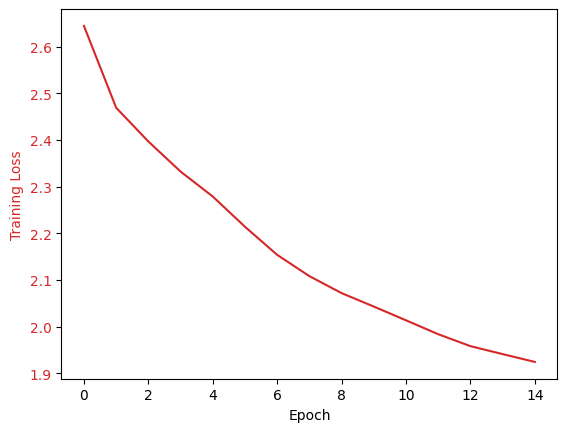

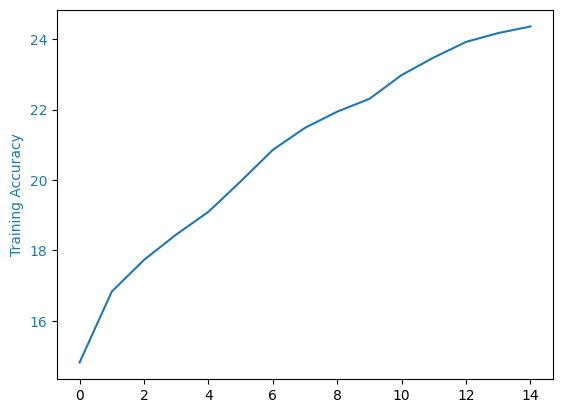

Correlation Table:
    0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0 3846592 33973  4292  2006   380   565   328   108   976   424    29    23  1055    16     0    62     7    15    16  1273    18    10   121   413     7     0   354
    0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0 574029 57100 15524  4400  2830  1527   541   265  2380  1621    37    39  2200    10     0   260     6     4    14    26    38     0    25   102     1     0    81
    0     0     0 99240 755764 30665 35640 31509 22038  5901 18053  7304  6248   488   185 14977   199    46  2099  1959  1080  2705   145   252    40    31   130     0     0    87
    0     0     0 68584 107717 87470 10914  3440 24201  5312 12232  2394  175

In [36]:
model1, criterian1 = train(ENC_EMB_DIM = 16, DEC_EMB_DIM = 16 , HID_DIM = 16, N_LAYERS = 1, ENC_DROPOUT = 0.5, DEC_DROPOUT= 0.5)

In [37]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    
    with torch.no_grad():
        for batch in iterator:
            src = batch.source
            trg = batch.target

            output = model(src, trg) # Turn off teacher forcing

            # trg = [trg len, batch size]
            # output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            # trg = [(trg len - 1) * batch size]
            # output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            epoch_loss += loss.item()

            # compute accuracy
            pred = torch.argmax(output, dim=1) # predicted character index
            non_pad_mask = trg != target_field.vocab.stoi['<pad>'] # mask padding positions
            num_correct = torch.sum(pred[non_pad_mask] == trg[non_pad_mask])
            num_non_pad = torch.sum(non_pad_mask)
            acc = num_correct.float() / num_non_pad
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), (epoch_acc / len(iterator)) * 100


test_dataset = TabularDataset(path=test_path, format='tsv', fields=[('source', source_field), ('target', target_field)])
test_iter = BucketIterator(
    dataset=test_dataset,
    batch_size=32,
    device=device
)



In [38]:
test_loss, acc = evaluate(model1, test_iter, criterian1)
print(f'Test Loss: {test_loss:.3f} | Test Accuracy : {acc: .3f}%')

Test Loss: 1.823 | Test Accuracy :  44.543


Train model for Input Embedding:64 | number of encoding and decoding layers : 3 | Hidden layer Size : 64 
Epoch: 1, Training Loss: 2.538, Training Accuracy: 16.04%
Epoch: 2, Training Loss: 2.150, Training Accuracy: 21.15%
Epoch: 3, Training Loss: 1.700, Training Accuracy: 27.83%
Epoch: 4, Training Loss: 1.456, Training Accuracy: 31.58%
Epoch: 5, Training Loss: 1.306, Training Accuracy: 34.10%
Epoch: 6, Training Loss: 1.200, Training Accuracy: 35.93%
Epoch: 7, Training Loss: 1.135, Training Accuracy: 37.03%
Epoch: 8, Training Loss: 1.083, Training Accuracy: 37.97%
Epoch: 9, Training Loss: 1.038, Training Accuracy: 38.75%
Epoch: 10, Training Loss: 1.003, Training Accuracy: 39.34%
Epoch: 11, Training Loss: 0.981, Training Accuracy: 39.69%
Epoch: 12, Training Loss: 0.950, Training Accuracy: 40.39%
Epoch: 13, Training Loss: 0.934, Training Accuracy: 40.53%
Epoch: 14, Training Loss: 0.914, Training Accuracy: 40.96%
Epoch: 15, Training Loss: 0.899, Training Accuracy: 41.31%
Time taken:  84.68

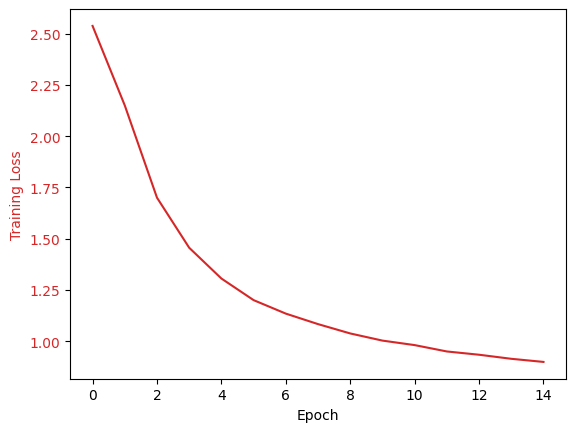

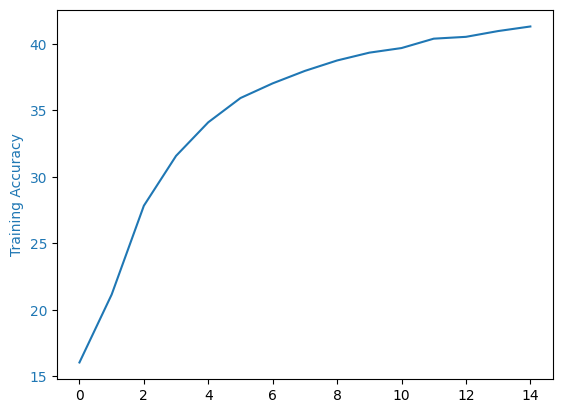

Correlation Table:
    0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0 3819423 15676 16169 10023 12112  3342  1549  1877  1472   840   830  1508  1403    23   765   580   816   133    93   293   118   110     0    15     1     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0 569138 31099 13461  9458  3319  5469  6007  3465  4785  2751  2409  1932  2948   268  1550  2070   708   482   250   803   181   423     1    81     2     0     0
    0     0     0 63241 723700 32302 22888 22015 32974 22992 16651  9640  8403 11435  9009 14011  4128  8882  9392  5730  6960  3261  4226  1106  3205   374   253     2     5     0
    0     0     0 29287 54361 218974  6354  1879  5106  3630  4605  3272  554

In [39]:
model2, criterian2 = train(ENC_EMB_DIM = 64, DEC_EMB_DIM = 64 , HID_DIM = 64, N_LAYERS = 3, ENC_DROPOUT = 0.5, DEC_DROPOUT= 0.5)


In [40]:
test_loss, acc = evaluate(model2, test_iter, criterian2)
print(f'Test Loss: {test_loss:.3f} | Test Accuracy : {acc: .3f}%')

Test Loss: 0.713 | Test Accuracy :  77.130


# LSTM with attention layer

## Encoder

In [53]:
class EncoderAtt(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super(EncoderAtt, self).__init__()
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, bidirectional = True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

        self.fc_hidden = nn.Linear(hid_dim*2, hid_dim)
        self.fc_cell = nn.Linear(hid_dim*2, hid_dim)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        enc_states, (hidden, cell) = self.rnn(embedded)

        hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim = 2))
        cell = self.fc_cell(torch.cat((cell[0:1], cell[1:2]), dim = 2))
        return enc_states,hidden, cell

## Decoder

In [54]:
class DecoderAtt(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super(DecoderAtt, self).__init__()
        self.output_dim = output_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.energy = nn.Linear(hid_dim*3, 1)
        self.softmax = nn.Softmax(dim = 0)
        self.relu = nn.ReLU()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(hid_dim*2 + emb_dim, hid_dim, n_layers, dropout=dropout)
        self.out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, enc_state, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))

        seq_len = enc_state.shape[0]
        h_reshaped = hidden.repeat(seq_len, 1, 1)
        energy = self.relu(self.energy(torch.cat((h_reshaped, enc_state), dim = 2)))
        attention = self.softmax(energy)
        attention = attention.permute(1, 0, 2)

        enc_state = enc_state.permute(1, 0, 2)

        context_vec = torch.bmm(attention, enc_state).permute(1, 0, 2)

        rnn_input = torch.cat((context_vec, embedded), dim = 2)

        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.out(output)

        prediction = prediction.squeeze(0)
        return prediction, hidden, cell

# Seq2Seq

In [55]:
class Seq2SeqAtt(nn.Module):
  def __init__(self, encoder, decoder, device):
    super(Seq2SeqAtt, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.device = device


  def forward(self, src, trg, teacher_forcing_ratio=0.5):
    batch_size = trg.shape[1]
    max_len = trg.shape[0]
    trg_vocab_size = self.decoder.output_dim
    
    outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
    
    enc_state, hidden, cell = self.encoder(src)
    
    input = trg[0,:]
    
    for t in range(1, max_len):
        output, hidden, cell = self.decoder(input, enc_state, hidden, cell)
        outputs[t] = output
        teacher_force = random.random() < teacher_forcing_ratio
        top1 = output.argmax(1)
        input = trg[t] if teacher_force else top1
    
    return outputs


In [56]:
def train(ENC_EMB_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, DEC_DROPOUT):
    enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
    dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
    model = Seq2Seq(enc, dec, device).to(device)

    print(f"Train model for Input Embedding:{ENC_EMB_DIM} | number of encoding and decoding layers : {N_LAYERS} | Hidden layer Size : {HID_DIM} ")

    # Define the optimizer and the loss function
    criterion = nn.CrossEntropyLoss(ignore_index=target_field.vocab.stoi['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    N_EPOCHS = 15
    CLIP = 1
    start = time.time()

    corr_tbl = torch.zeros((OUTPUT_DIM, OUTPUT_DIM), dtype=torch.long)
    total_correct = 0
    total_tokens = 0
    
    train_losses = []
    train_accs = []

    for epoch in range(N_EPOCHS):
        epoch_loss = 0
        epoch_correct = 0
        epoch_tokens = 0
        model.train()
        
        for batch in train_iter:
            src = batch.source
            trg = batch.target
            optimizer.zero_grad()
            
            output = model(src, trg)
            
            # trg = [trg len, batch size]
            # output = [trg len, batch size, output dim]
            
            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            
            # trg = [(trg len - 1) * batch size]
            # output = [(trg len - 1) * batch size, output dim]
            
            loss = criterion(output, trg)
            loss.backward()
            
            # Clip the gradients to prevent them from exploding
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
            
            optimizer.step()
            epoch_loss += loss.item()

            # Calculate accuracy and update correlation table
            pred = output.argmax(dim=1)
            correct = pred.eq(trg).sum().item()
            epoch_correct += correct
            total_correct += correct
            epoch_tokens += trg.shape[0]
            total_tokens += trg.shape[0]
            for i, p in enumerate(pred):
                corr_tbl[trg[i]][p] += 1
        
        train_loss = epoch_loss / len(train_iter)
        train_losses.append(train_loss)

        # Calculate accuracy for this epoch
        epoch_accuracy = (epoch_correct / epoch_tokens) * 100
        train_accs.append(epoch_accuracy)

        print(f'Epoch: {epoch+1}, Training Loss: {train_loss:.3f}, Training Accuracy: {epoch_accuracy:.2f}%')
        

    end = time.time()
    print(f"Time taken:  {(end- start) / N_EPOCHS}")
    # Plot training loss and accuracy for all epochs
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training Loss', color=color)
    ax1.plot(train_losses, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    plt.show()
    fig, ax2 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax2.set_ylabel('Training Accuracy', color=color)
    ax2.plot(train_accs, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()

    print('Correlation Table:')
    for i in range(OUTPUT_DIM):
        row = " ".join([f"{corr_tbl[i][j]:5}" for j in range(OUTPUT_DIM)])
        print(row)

    return model, criterion


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Train model for Input Embedding:16 | number of encoding and decoding layers : 1 | Hidden layer Size : 16 
Epoch: 1, Training Loss: 2.654, Training Accuracy: 15.04%
Epoch: 2, Training Loss: 2.469, Training Accuracy: 17.00%
Epoch: 3, Training Loss: 2.377, Training Accuracy: 18.16%
Epoch: 4, Training Loss: 2.299, Training Accuracy: 19.21%
Epoch: 5, Training Loss: 2.219, Training Accuracy: 20.02%
Epoch: 6, Training Loss: 2.145, Training Accuracy: 20.80%
Epoch: 7, Training Loss: 2.090, Training Accuracy: 21.43%
Epoch: 8, Training Loss: 2.046, Training Accuracy: 22.07%
Epoch: 9, Training Loss: 2.013, Training Accuracy: 22.51%
Epoch: 10, Training Loss: 1.985, Training Accuracy: 22.95%
Epoch: 11, Training Loss: 1.960, Training Accuracy: 23.31%
Epoch: 12, Training Loss: 1.931, Training Accuracy: 23.70%
Epoch: 13, Training Loss: 1.909, Training Accuracy: 24.21%
Epoch: 14, Training Loss: 1.888, Training Accuracy: 24.44%
Epoch: 15, Training Loss: 1.868, Training Accuracy: 24.78%
Time taken:  66.01

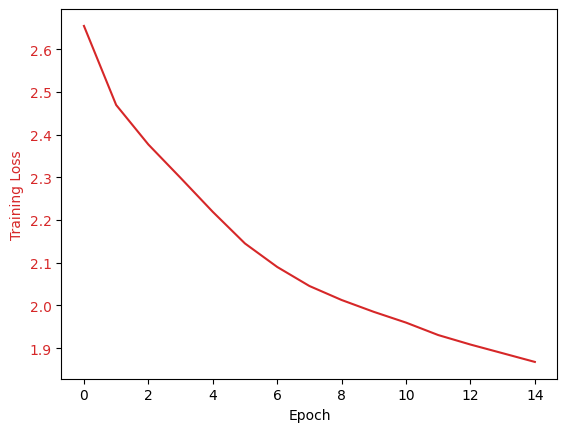

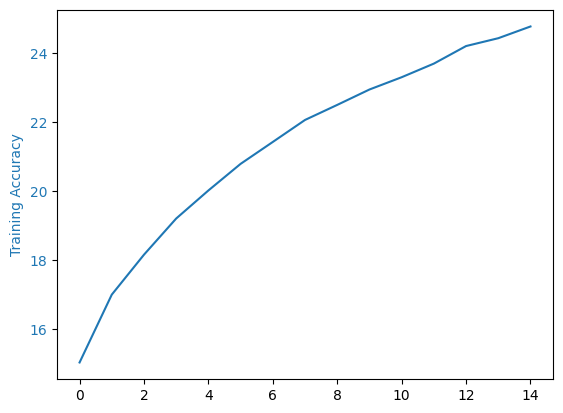

Correlation Table:
    0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0
  349   930     0 3853078 27596  4964   767   200  2068  1344     6   165    11   166    39   755   519     0    71   295     2     0   106     0   147  1739    14     0    76     0
    0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0
   96    67     0 569838 61395 14943  1636  2370  6406  3311    68   263   161   153   303  1539    74     0    43   132    10     0    72     0    36   130     3     0    11     0
  146    63     0 109500 743663 41218  9755 36030 40737 13854 12569   504  1752  4590  3055 11032  2720  1350   343   887  1060   736   770    24   293   117     6     0    11     0
   57    34     0 69017 106556 127640  1332  1899 10587  5109 14919   181   

In [57]:
model1, criterian1 = train(ENC_EMB_DIM = 16, DEC_EMB_DIM = 16 , HID_DIM = 16, N_LAYERS = 1, ENC_DROPOUT = 0.5, DEC_DROPOUT= 0.5)

In [58]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    
    with torch.no_grad():
        for batch in iterator:
            src = batch.source
            trg = batch.target

            output = model(src, trg) # Turn off teacher forcing

            # trg = [trg len, batch size]
            # output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            # trg = [(trg len - 1) * batch size]
            # output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            epoch_loss += loss.item()

            # compute accuracy
            pred = torch.argmax(output, dim=1) # predicted character index
            non_pad_mask = trg != target_field.vocab.stoi['<pad>'] # mask padding positions
            num_correct = torch.sum(pred[non_pad_mask] == trg[non_pad_mask])
            num_non_pad = torch.sum(non_pad_mask)
            acc = num_correct.float() / num_non_pad
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), (epoch_acc / len(iterator)) * 100


test_dataset = TabularDataset(path=test_path, format='tsv', fields=[('source', source_field), ('target', target_field)])
test_iter = BucketIterator(
    dataset=test_dataset,
    batch_size=32,
    device=device
)



In [59]:
test_loss, acc = evaluate(model1, test_iter, criterian1)
print(f'Test Loss: {test_loss:.3f} | Test Accuracy : {acc: .3f}%')

Test Loss: 1.711 | Test Accuracy :  46.928%


Train model for Input Embedding:64 | number of encoding and decoding layers : 3 | Hidden layer Size : 64 
Epoch: 1, Training Loss: 2.524, Training Accuracy: 16.15%
Epoch: 2, Training Loss: 2.098, Training Accuracy: 21.94%
Epoch: 3, Training Loss: 1.663, Training Accuracy: 28.43%
Epoch: 4, Training Loss: 1.431, Training Accuracy: 32.02%
Epoch: 5, Training Loss: 1.290, Training Accuracy: 34.34%
Epoch: 6, Training Loss: 1.199, Training Accuracy: 35.81%
Epoch: 7, Training Loss: 1.126, Training Accuracy: 37.18%
Epoch: 8, Training Loss: 1.075, Training Accuracy: 38.10%
Epoch: 9, Training Loss: 1.034, Training Accuracy: 38.89%
Epoch: 10, Training Loss: 1.004, Training Accuracy: 39.34%
Epoch: 11, Training Loss: 0.972, Training Accuracy: 39.89%
Epoch: 12, Training Loss: 0.948, Training Accuracy: 40.35%
Epoch: 13, Training Loss: 0.927, Training Accuracy: 40.79%
Epoch: 14, Training Loss: 0.910, Training Accuracy: 41.09%
Epoch: 15, Training Loss: 0.891, Training Accuracy: 41.44%
Time taken:  86.08

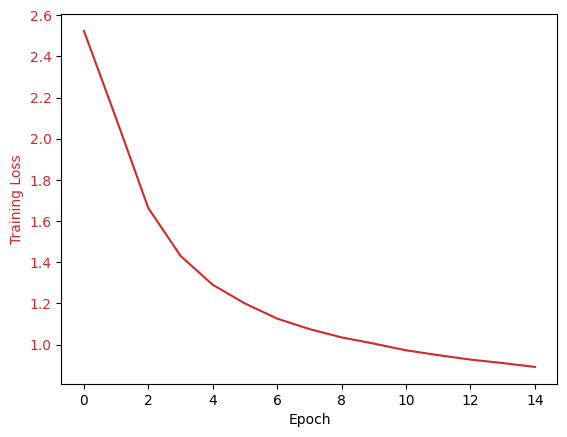

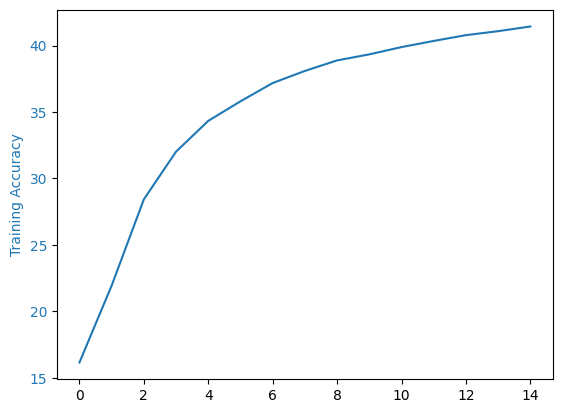

Correlation Table:
    0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0 3832099 20785 13388  8732  1278  3667  1717  1521  2755   572  1204  1351  1024     8   920   697   179   121   149   228    90   104     0    10     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0 568306 31213 13873  8534  3383  5917  6142  3229  5068  3215  2359  2094  3291   305  1302  2093   606   442   279   712   226   387     3    80     0     1     0
    0     0     0 63642 724256 32837 19256 21391 34102 24168 16525 10657  8105 11619 10207 16583  3461  8436  8223  4439  6537  3671  3620  1051  3387   329   275     8     0     0
    0     0     0 29855 48345 221159  6140  1725  4679  6092  4374  3780  575

In [60]:
model2, criterian2 = train(ENC_EMB_DIM = 64, DEC_EMB_DIM = 64 , HID_DIM = 64, N_LAYERS = 3, ENC_DROPOUT = 0.5, DEC_DROPOUT= 0.5)


In [61]:
test_loss, acc = evaluate(model2, test_iter, criterian2)
print(f'Test Loss: {test_loss:.3f} | Test Accuracy : {acc: .3f}%')

Test Loss: 0.684 | Test Accuracy :  78.317%
